In [14]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from test_saliency.utils import decode, aaMap_jurtz, convertPredictQ8Result2HumanReadable

### Loading data

In [15]:
from secondary_proteins_prediction import data

TRAIN_PATH = 'secondary_proteins_prediction/data/cullpdb+profile_6133_filtered.npy.gz'
TEST_PATH = 'secondary_proteins_prediction/data/cb513+profile_split1.npy.gz'

X_train, X_valid, labels_train, labels_valid, mask_train, mask_valid, _ = data.get_train(TRAIN_PATH)
X_test, mask_test, labels_test, _ = data.get_test(TEST_PATH)
print X_train[:-30].shape, X_valid.shape, X_test[:-126].shape
split_value = len(X_train[:-30]) + len(X_valid)
print split_value

X = np.concatenate((X_train[:-30],X_valid, X_test[:-126]))
labels = np.concatenate((labels_train[:-30],labels_valid, labels_test[:-126]))
mask = np.concatenate((mask_train[:-30],mask_valid, mask_test[:-126]))
print X.shape

Train path is downloaded ...
Loading train data ...
Loading splits ...
Loading test data ...
(5248, 700, 42) (256, 700, 42) (514, 700, 42)
5504
(6018, 700, 42)


In [28]:
predictions_path = "secondary_proteins_prediction/predictions/predictions_train_valid_pureConv-20180804-010835-47.npy"
predictions = np.load(predictions_path)
print "train_val", predictions.shape

predictions_path = "secondary_proteins_prediction/predictions/predictionstest_pureConv-20180804-010835-47.npy"
predictions2 = np.load(predictions_path)
print "test", predictions2[:-126].shape

predictions = np.concatenate((predictions, predictions2[:-126]))
print "total", predictions.shape

lengths_train = np.sum(mask[:split_value], axis=1)
lengths_test = np.sum(mask[split_value:], axis=1)

train_val (5504, 700, 8)
test (514, 700, 8)
total (6018, 700, 8)


122 QVEISXAEWDVXNIIWDKKSVSANEIVVEIQKYKEVSDKTIRTLITRLYKKEIIKRYKSENIYFYSSNIKEDDIKXKTAKTFLNKLYGGDXKSLVLNFAKNEELNNKEIEELRDILNDISKK
('Allelujah!!', 'MTNKQVEISMAEWDVMNIIWDKKSVSANEIVVEIQKYKEVSDKTIRTLITRLYKKEIIKRYKSENIYFYSSNIKEDDIKMKTAKTFLNKLYGGDMKSLVLNFAKNEELNNKEIEELRDILNDISKK')
>1SD4A C4E672CF5FA718E7 126 XRAY  2.000  0.210  0.237 no Penicillinase repressor <BLAI_STAAU(1-126)> [Staphylococcus aureus]
KXKTAKTFLNKLYGGDXKSLVLNFAK
KMKTAKTFLNKLYGGDMKSLVLNFAK


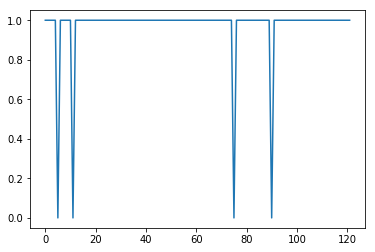

In [172]:
seq = 4

end_seq = int(sum(mask[seq]))
af = decode(X[seq,:end_seq,:21], aaMap_jurtz)
print end_seq, af

preds = convertPredictQ8Result2HumanReadable( predictions[seq] )
#print preds[:end_seq]

sss = pd.Series([el for el in preds[:end_seq]])
#print sss.value_counts()

a = []
q = 'FDYQTVYFANQYGLRTIELGESEFVDNTLDNQHKXVIKAAWGGGYT'
cut = 105
with open('test_saliency/pdbaa','r') as f:
    for a_line in f:
        a.append(a_line[:-1])
        if a_line == "\n":
            ala = "".join(a[1:])
            if ala[8:cut] in af and len(ala)>=cut or '>1SD4' in a[0]:
                print("Allelujah!!", ala)
                print a[0]
                step = 4
                plt.plot([af[i] == ala[i+step] for i in range(len(ala)-step)])
                print af[74:100]
                print ala[74+step:100+step]
                break
            a = []

In [163]:
hits = 0
for seq in range(len(X)):
    end_seq = int(sum(mask[seq]))
    af = decode(X[seq,:end_seq,:21], aaMap_jurtz)
    with open('test_saliency/pdbaa','r') as f:
        a = []
        for a_line in f:
            a.append(a_line[:-1])
            if a_line == "\n":
                ala = "".join(a[1:])
                if af in ala:
                    hits += 1
                    #print a[0]
                    break
                a = []
print hits

4696


In [138]:
lengths = pd.Series(lengths_train)
lengths.value_counts()[3.0]

KeyError: 3.0

### Spot best predictors

In [ ]:
for target_class in range(8):
    print "Class ", ssConvertMap[target_class]

    max_target = np.argmax( predictions[:, :, target_class] )
    max_target = np.unravel_index( max_target, predictions.shape[0:2] )
    seq = max_target[0]
    pos = max_target[1]
    
    print "max_target", max_target
    print "value: ", predictions[seq, pos, target_class]

    if pos >= window:
        init = pos - window
    else:
        init = 0
    end = pos + window + 1
    
    gato = decode( X_am[seq] )
    print "Aminoacids ", gato[ init:pos ], gato[ pos ], gato[ pos+1:end ]
    perro = convertPredictQ8Result2HumanReadable( predictions[seq] )
    print "Predictions", perro[init:pos], perro[pos], perro[pos+1:end]
    conejo = "".join([ssConvertMap[el] for el in labels[seq]])
    print "True labels", conejo[init:pos], conejo[pos], conejo[pos+1:end], "\n"

------------------------------------------------

## Analyze sequence predictions

In [ ]:
def calculate_seq_accuracy(predictions, labels):
    num_seq = len(mask)
    seq_len = predictions.shape[1]

    tot_acc = 0
    seq_acc = np.zeros(num_seq)
    for seq in range(num_seq):
        for pos in range(seq_len):
            if mask[seq,pos]:
                if labels[seq, pos] == np.argmax(predictions[seq, pos]):
                    seq_acc[seq] += 1
                    tot_acc +=1
            else:
                break

        seq_acc[seq] /= np.sum(mask[seq])
    
    print tot_acc / np.sum(mask)
    return seq_acc

seq_acc = calculate_seq_accuracy(predictions, labels)
seq_acc_train = seq_acc[:split_value]
seq_acc_test = seq_acc[split_value:]

lengths_train = np.sum(mask[:split_value], axis=1)
lengths_test = np.sum(mask[split_value:], axis=1)
print len(lengths_train[lengths_train > 300])
print len(lengths_test[lengths_test > 300])

### Per-sequence accuracy plots

In [1]:
def print_sorted_seqs(seqs, ax, label):
    ax.plot(sorted(seqs), marker="X", linewidth=0)
    ax.set(title='Per-sequence accuracy ('+label+')', ylim=[0, 1])

fig,ax = plt.subplots(2,2, figsize=(15,7))

print_sorted_seqs(seq_acc_train, ax[0][0], "train")
print_sorted_seqs(seq_acc_test, ax[0][1], "test")

print_sorted_seqs(seq_acc_train[lengths_train > 300], ax[1][0], 'train > 300')
print_sorted_seqs(seq_acc_test[lengths_test > 300], ax[1][1], 'test > 300')

NameError: name 'plt' is not defined

### Accuracy-size plots

In [ ]:
def print_length_vs_acc(lengths, seqs, ax, label):
    seq_len = 700
    
    ax.plot(lengths, seqs, marker="X", linewidth=0, label="sequences")
    ax.plot(np.mean(seqs)*np.ones(seq_len), label="mean")
    ax.set(title='Per-sequence accuracy ('+label+'), mean: {:.2f}'.format(np.mean(seqs)),
           ylabel="accuracy", xlabel="sequence length", ylim=[0, 1])
    ax.legend()

fig,ax = plt.subplots(2,2, figsize=(20,10))

print_length_vs_acc(lengths_train, seq_acc_train, ax[0][0], 'train')
print_length_vs_acc(lengths_test, seq_acc_test, ax[0][1], 'test')

print_length_vs_acc(lengths_train[lengths_train > 300], seq_acc_train[lengths_train > 300], ax[1][0], 'train')
print_length_vs_acc(lengths_test[lengths_test > 300], seq_acc_test[lengths_test > 300], ax[1][1], 'test')